# Topic Modelling example
## Following a tutorial and explanation of Topic Modelling
<br/>

### Importing Packages and the Dataset:
To start, some importing needs to be done,
this includes; a list of stopwords, newsgroup(online forum) dataset, lemmatization tools, Gensim, and others.
<br/>
<br/>

In [2]:
import nltk;
nltk.download('stopwords')

#using the natural language toolkit to download a list of stopwords e.g.

#-these are words that don't hold any topic or meaning
#and are only useful for putting together a sentance

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tobia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

#importing packages that will be used later

In [4]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'ax'])

In [5]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())
df.head()

#dowloading the newsgroups dataset to use later for clustering into topics
#-the first few lines of this data are shown below;

['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


### Preparing the data:
the data has to be reformatted and filtered to build a working topic model
<br/>
<br/>

In [6]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

#overall, this simplifies the data into a more usable format,
#by removing unnecessary text like emails or formatting code

['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']


In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

#this removes punctuation like commas or dots from the list
#and also converts it into individual words

[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

#a bigram is a combiation of two words that are commonly written together,
#a trigram is the same but with 3 words etc.

#this code defines what is considered as a bigram
#using parameters like minimum count,
#(the minimum number of times a given combination of words must appear
#in the text to be considered a bigram)
#or threshold

['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting_host', 'rac_wam_umd_edu', 'organization', 'university', 'of', 'maryland_college_park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


In [9]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatisation(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    #*
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

#*lemmatisation is the abstactification of words into their root form
#e.g running or ran both become run

#this defines functions to lemmitise, remove stopwords from and
# make bigrams and trigrams from the dataset

In [10]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatised = lemmatisation(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatised[:1])

#applies the previous functions to the dataset

[['s', 'thing', 'car', 'nntp_poste', 'host', 'park', 'line', 'wonder', 'enlighten', 'car', 'see', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'door', 'really', 'small', 'addition', 'separate', 'rest', 'body', 'know', 'tellme', 'model', 'name', 'engine', 'spec', 'year', 'production', 'car', 'make', 'history', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']]


In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatised)

# Create Corpus
texts = data_lemmatised

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

#creates dictionary and corpus to filter out names
#and other unrecognised text not included in the english dictionary
#from the list of words

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 5), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1)]]


## Building the Topic Model
All the preperation is finished and now the LDA model can be made.
<br/>
<br/>

In [12]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

#this sets up the parameters for the topic model

In [13]:
# Print the Keyword in the 20 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

#This is the topic model, it has made 20 topics, and this shows
#the top 10 keywords in each topic and their weight

[(0,
  '0.022*"say" + 0.018*"think" + 0.018*"people" + 0.017*"go" + 0.016*"make" + '
  '0.015*"know" + 0.014*"see" + 0.011*"come" + 0.011*"well" + 0.011*"thing"'),
 (1,
  '0.069*"team" + 0.065*"game" + 0.045*"play" + 0.040*"win" + 0.036*"year" + '
  '0.032*"player" + 0.023*"run" + 0.020*"hit" + 0.017*"trade" + 0.017*"score"'),
 (2,
  '0.084*"drug" + 0.048*"proof" + 0.046*"terrorism" + 0.034*"blind" + '
  '0.031*"homosexual" + 0.028*"economic" + 0.028*"rise" + 0.028*"percent" + '
  '0.019*"investigation" + 0.018*"whole"'),
 (3,
  '0.068*"wing" + 0.053*"signal" + 0.042*"circuit" + 0.030*"dual" + '
  '0.028*"cap" + 0.027*"fuel" + 0.027*"laboratory" + 0.025*"floor" + '
  '0.024*"pointer" + 0.023*"travel"'),
 (4,
  '0.030*"car" + 0.023*"buy" + 0.021*"get" + 0.020*"good" + 0.020*"price" + '
  '0.018*"sell" + 0.017*"sale" + 0.017*"d" + 0.016*"cost" + 0.015*"pay"'),
 (5,
  '0.045*"kill" + 0.031*"child" + 0.027*"war" + 0.025*"death" + 0.024*"attack" '
  '+ 0.024*"soldier" + 0.022*"armenian" + 0

In [14]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatised, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

#this calculates scores for the topic model based on some factors


Perplexity:  -13.822949202133325

Coherence Score:  0.48517145463712097


### Visualisation
Now it's time to visualise the topic model and see the results.
<br/>
<br/>

In [15]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

#Each bubble in the plot is a model and the size represents
#how prevelant that topic is. 
#The axis are principle component 1 & 2
#so the distance between bubbles correlates to how similar they are.

#This model is ok but you can see that there is too much overlapping of bubbles
#and the bubbles on the left are very small and close together rather than spread apart
#which is not ideal.

C:\Users\tobia\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.332668 -0.064577       1        1  34.044845
15     0.278534 -0.115060       2        1  15.579944
13     0.268648  0.116071       3        1  10.753444
10     0.196969  0.214021       4        1   8.864493
16     0.153587 -0.070255       5        1   6.113288
4      0.199523  0.059822       6        1   5.936222
14     0.097198  0.152741       7        1   4.078034
1      0.071011 -0.063878       8        1   2.780606
18     0.011976 -0.240043       9        1   2.689745
5      0.005528 -0.235304      10        1   2.392542
19    -0.025594  0.105884      11        1   1.782725
8     -0.126765  0.025182      12        1   1.165676
11    -0.144522  0.008202      13        1   0.728169
7     -0.161255  0.020881      14        1   0.724318
17    -0.180792  0.008198      15        1   0.555415
2     -0.182269  0.019439      16        1   0.470639
3     -0.183684  0.016503      17        1   0.446942
9     -0.197220  0.015223      18        1   0.370099
6     -0.208052  0.013780      19        1   0.276437
12    -0.205490  0.013171      20        1   0.246419, topic_info=               Term          Freq         Total Category  logprob  loglift
17             line  16364.000000  16364.000000  Default  30.0000  30.0000
206           write  13252.000000  13252.000000  Default  29.0000  29.0000
143    organization   8782.000000   8782.000000  Default  28.0000  28.0000
44          article   9455.000000   9455.000000  Default  27.0000  27.0000
24       nntp_poste   6653.000000   6653.000000  Default  26.0000  26.0000
...             ...           ...           ...      ...      ...      ...
8181         deeply      0.034494      1.219252  Topic20 -11.3725   2.4407
11228          bend      0.034494      1.219260  Topic20 -11.3725   2.4407
4981          clone      0.034494      1.219272  Topic20 -11.3725   2.4407
5490        uranium      0.034492      1.219237  Topic20 -11.3726   2.4406
3892          slave      0.034495      1.219421  Topic20 -11.3725   2.4406

[891 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
86        3  0.045072    access
86        7  0.953791    access
622       5  0.998446  activity
183       3  0.999528   address
3138     14  0.985939    adjust
...     ...       ...       ...
206       4  0.780695     write
472       1  0.999014     wrong
39        2  0.754214      year
39        8  0.245577      year
2594      9  0.995883      zone

[1164 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 16, 14, 11, 17, 5, 15, 2, 19, 6, 20, 9, 12, 8, 18, 3, 4, 10, 7, 13])

### Building Another Topic Model
This time the topic model will have only 12 topics instead of 20

In [16]:
# Build LDA model
lda_model2 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=12, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [17]:
# Print the Keyword in the 10 topics
pprint(lda_model2.print_topics())
doc_lda2 = lda_model2[corpus]

[(0,
  '0.019*"say" + 0.017*"people" + 0.010*"think" + 0.010*"make" + '
  '0.008*"believe" + 0.008*"know" + 0.008*"many" + 0.008*"see" + '
  '0.008*"reason" + 0.007*"point"'),
 (1,
  '0.036*"team" + 0.034*"game" + 0.026*"year" + 0.024*"play" + 0.021*"win" + '
  '0.017*"player" + 0.012*"hockey" + 0.010*"run" + 0.009*"lose" + '
  '0.009*"trade"'),
 (2,
  '0.016*"kill" + 0.014*"war" + 0.014*"israeli" + 0.013*"soldier" + '
  '0.012*"attack" + 0.012*"armenian" + 0.012*"existence" + 0.012*"child" + '
  '0.011*"village" + 0.011*"greek"'),
 (3,
  '0.053*"internet" + 0.033*"item" + 0.026*"food" + 0.025*"material" + '
  '0.024*"recommend" + 0.023*"eat" + 0.021*"upgrade" + 0.013*"oil" + '
  '0.013*"cap" + 0.013*"specify"'),
 (4,
  '0.044*"line" + 0.031*"write" + 0.028*"get" + 0.026*"organization" + '
  '0.024*"article" + 0.020*"nntp_poste" + 0.018*"go" + 0.015*"host" + '
  '0.015*"m" + 0.014*"know"'),
 (5,
  '0.060*"law" + 0.039*"state" + 0.037*"government" + 0.024*"right" + '
  '0.019*"protect" 

In [18]:
# Compute Perplexity
print('\nPerplexity: ', lda_model2.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda2 = CoherenceModel(model=lda_model2, texts=data_lemmatised, dictionary=id2word, coherence='c_v')
coherence_lda2 = coherence_model_lda2.get_coherence()
print('\nCoherence Score: ', coherence_lda2)


Perplexity:  -10.122437187911329

Coherence Score:  0.4892923793001985


In [19]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model2, corpus, id2word)
vis

#Reducing the topic model to 12 topics has somewhat improved the results
#the topics seem to be more spread apart and there are less small topics bunched up together
#however there are still some of the same issues like topic 1 & 2 overlapping
#and unbalanced relevancy of the topics

C:\Users\tobia\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.280871  0.129220       1        1  31.567273
4     -0.287909  0.112308       2        1  24.466920
10    -0.226439 -0.121729       3        1  12.808926
9     -0.063377 -0.294850       4        1   6.414160
8     -0.005768 -0.069163       5        1   5.998420
11    -0.020635 -0.168575       6        1   5.471254
1     -0.022335  0.156725       7        1   4.513974
2      0.042356  0.174261       8        1   3.861123
5      0.172612  0.073782       9        1   2.222810
3      0.226916 -0.006800      10        1   1.151633
7      0.229067  0.010423      11        1   0.779708
6      0.236382  0.004399      12        1   0.743800, topic_info=               Term          Freq         Total Category  logprob  loglift
17             line  15099.000000  15099.000000  Default  30.0000  30.0000
130               m   4889.000000   4889.000000  Default  29.0000  29.0000
206           write  11961.000000  11961.000000  Default  28.0000  28.0000
143    organization   8050.000000   8050.000000  Default  27.0000  27.0000
113             get   9117.000000   9117.000000  Default  26.0000  26.0000
...             ...           ...           ...      ...      ...      ...
3473         buffer     64.874665     65.947200  Topic12  -4.9378   4.8848
2026        segment     63.068214     64.140750  Topic12  -4.9661   4.8843
4105          sleep     61.163104     62.235658  Topic12  -4.9967   4.8838
12434        column     59.761849     60.834389  Topic12  -5.0199   4.8834
6138       numerous     56.541616     57.614172  Topic12  -5.0753   4.8824

[584 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
4326     11  0.997549           _
4195      5  0.953412     ability
4195      7  0.045043     ability
1342      1  0.998758      accept
5567      9  0.994571  acceptable
...     ...       ...         ...
39        5  0.083938        year
39        6  0.086336        year
39        7  0.347264        year
39        8  0.054200        year
5283     12  0.990634       youth

[844 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 11, 10, 9, 12, 2, 3, 6, 4, 8, 7])

### Building LDA Model
Building an improved topic model with mallet
<br/>
<br/>

In [31]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = r'C:\Users\tobia\Downloads\mallet-2.0.8\mallet-2.0.8\bin\mallet'

import os
os.environ['MALLET_HOME'] = r'C:\Users\tobia\Downloads\mallet-2.0.8\mallet-2.0.8'

ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

#Downloads mallet with Gensim wrapper


KeyboardInterrupt



In [32]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatised, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

#These are the new topics and coherence score

[(11,
  [('car', 0.038348411248273095),
   ('buy', 0.019274477472258123),
   ('price', 0.017982084763135613),
   ('sale', 0.016823387851508536),
   ('sell', 0.016400017826106332),
   ('bike', 0.014661972458665715),
   ('drive', 0.01062881590088685),
   ('ride', 0.010584250635055038),
   ('good', 0.00909131422968938),
   ('engine', 0.008489683140959936)]),
 (5,
  [('line', 0.16783292356739524),
   ('nntp_poste', 0.12917083186988357),
   ('host', 0.10282873584956637),
   ('organization', 0.0910220733255883),
   ('reply', 0.044687001864209874),
   ('keyword', 0.018777186393969688),
   ('mail', 0.017399292140599248),
   ('university', 0.015481047199632562),
   ('interested', 0.012833328830410936),
   ('phone', 0.010563855942506686)]),
 (19,
  [('people', 0.013322493944320935),
   ('man', 0.013090221322626671),
   ('christian', 0.012028403623452899),
   ('word', 0.01141454026611806),
   ('church', 0.009440222981716826),
   ('religion', 0.008428177987191823),
   ('life', 0.008394996184092644

KeyboardInterrupt: 

### Finding the optimal number of topics
Calculating the coherence scores of Topic models with different numbers of topics to find the best one.
<br/>
<br/>

In [22]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

#this creates 7 models with different numbers of topics

In [23]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatised, start=2, limit=40, step=6)

#this calculates the coherency of each model

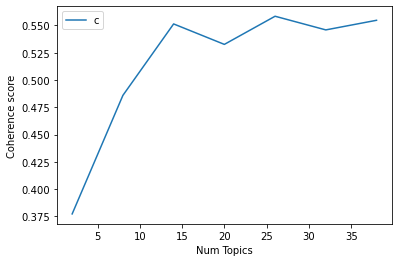

In [33]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

#This graph shows the coherency of the different topic models

In [25]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3773
Num Topics = 8  has Coherence Value of 0.4859
Num Topics = 14  has Coherence Value of 0.5513
Num Topics = 20  has Coherence Value of 0.5326
Num Topics = 26  has Coherence Value of 0.5584
Num Topics = 32  has Coherence Value of 0.5458
Num Topics = 38  has Coherence Value of 0.5547


In [26]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.038*"mail" + 0.024*"line" + 0.022*"price" + 0.022*"list" + 0.021*"send" + '
  '0.020*"sell" + 0.019*"sale" + 0.018*"email" + 0.018*"computer" + '
  '0.015*"interested"'),
 (1,
  '0.025*"book" + 0.018*"system" + 0.014*"science" + 0.010*"write" + '
  '0.009*"theory" + 0.009*"moral" + 0.008*"reference" + 0.007*"find" + '
  '0.007*"result" + 0.006*"make"'),
 (2,
  '0.026*"question" + 0.022*"claim" + 0.019*"exist" + 0.018*"true" + '
  '0.016*"write" + 0.014*"evidence" + 0.014*"reason" + 0.013*"argument" + '
  '0.012*"point" + 0.011*"answer"'),
 (3,
  '0.019*"power" + 0.013*"line" + 0.011*"ground" + 0.010*"current" + '
  '0.009*"work" + 0.008*"wire" + 0.008*"run" + 0.007*"water" + 0.007*"unit" + '
  '0.007*"circuit"'),
 (4,
  '0.016*"people" + 0.015*"day" + 0.013*"time" + 0.013*"happen" + 0.013*"kill" '
  '+ 0.012*"start" + 0.012*"fire" + 0.011*"leave" + 0.009*"child" + '
  '0.009*"woman"'),
 (5,
  '0.033*"file" + 0.019*"program" + 0.018*"window" + 0.013*"image" + '
  '0.011*"versi

In [30]:
# Visualize the topics
pyLDAvis.enable_notebook()
converted_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)
vis = pyLDAvis.gensim_models.prepare(converted_model, corpus, id2word)
vis

# This topic model looks much better, all of the topics have a similar relevancy and are pretty spead out

C:\Users\tobia\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
C:\Users\tobia\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
C:\Users\tobia\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
5     -0.107985  0.247589       1        1  6.938238
13     0.124871  0.020888       2        1  5.793754
19     0.127370 -0.008560       3        1  5.774927
6      0.194868 -0.114582       4        1  5.726375
4      0.159077 -0.083293       5        1  5.723611
18     0.154110 -0.044351       6        1  5.528868
12     0.031988  0.173782       7        1  5.467067
16    -0.007021  0.200655       8        1  5.316448
2      0.082448 -0.120259       9        1  5.129938
17     0.104611 -0.181920      10        1  5.087844
11     0.037662 -0.043389      11        1  5.053299
9      0.076915 -0.019231      12        1  4.826469
14    -0.145009  0.233176      13        1  4.812263
1      0.070819  0.031026      14        1  4.615263
8      0.070237  0.000928      15        1  4.419522
3     -0.076854  0.101140      16        1  4.377634
10    -0.032879 -0.006626      17        1  4.334388
0     -0.203972  0.064877      18        1  4.179109
15    -0.306852 -0.257813      19        1  3.630009
7     -0.354404 -0.194039      20        1  3.264975, topic_info=                    Term          Freq         Total Category  logprob  \
206                write  11776.000000  11776.000000  Default  30.0000   
17                  line  14795.000000  14795.000000  Default  29.0000   
44               article   8505.000000   8505.000000  Default  28.0000   
143         organization   7390.000000   7390.000000  Default  27.0000   
24            nntp_poste   5828.000000   5828.000000  Default  26.0000   
...                  ...           ...           ...      ...      ...   
466           technology    170.424569   1182.479372  Topic20  -5.4512   
1265  greatly_appreciate     84.581082    142.825997  Topic20  -6.1518   
5902               cheer     83.318678    133.981242  Topic20  -6.1668   
89               advance     83.318678    482.505720  Topic20  -6.1668   
3794                math     83.318678    136.109158  Topic20  -6.1668   

      loglift  
206   30.0000  
17    29.0000  
44    28.0000  
143   27.0000  
24    26.0000  
...       ...  
466    1.4848  
1265   2.8980  
5902   2.9469  
89     1.6656  
3794   2.9311  

[1829 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
4326      4  0.003001          _
4326     14  0.012004          _
4326     20  0.984335          _
5720      3  0.991282   abortion
5720     18  0.007183   abortion
...     ...       ...        ...
39       12  0.317132       year
39       15  0.053763       year
612       4  0.821543       yhwh
2174     14  0.794165  zoologist
2175      6  0.991272       zuma

[3529 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 14, 20, 7, 5, 19, 13, 17, 3, 18, 12, 10, 15, 2, 9, 4, 11, 1, 16, 8])

### Using the topic model to classify text
The topic model can be used to classify documents into topics.
<br/>
<br/>

In [27]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
  
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

#This code is used to find the dominant topic for each document
#this mean the documents can be classified based on their contents

C:\Users\tobia\AppData\Local\Temp\ipykernel_7376\553901950.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
C:\Users\tobia\AppData\Local\Temp\ipykernel_7376\553901950.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,10,0.1897,"car, bike, buy, ride, drive, turn, engine, spe...",From: (wheres my thing) Subject: WHAT car is t...
1,1,14,0.1773,"drive, card, problem, system, bit, run, driver...",From: (Guy Kuo) Subject: SI Clock Poll - Final...
2,2,14,0.1384,"drive, card, problem, system, bit, run, driver...",From: (Thomas E Willis) Subject: PB questions....
3,3,15,0.0802,"write, article, line, organization, nntp_poste...",From: (Joe Green) Subject: Re: Weitek P9000 ? ...
4,4,13,0.1346,"make, question, group, point, time, change, gi...",From: (Jonathan McDowell) Subject: Re: Shuttle...
5,5,12,0.2503,"key, gun, encryption, system, public, security...",From: (Foxvog Douglas) Subject: Re: Rewording ...
6,6,8,0.1344,"drug, food, study, doctor, article, day, probl...",From: (brian manning delaney) Subject: Brain T...
7,7,14,0.5140,"drive, card, problem, system, bit, run, driver...",From: (GRUBB) Subject: Re: IDE vs SCSI Organiz...
8,8,7,0.1241,"line, nntp_poste, organization, host, universi...",From: Subject: WIn 3.0 ICON HELP PLEASE! Organ...
9,9,14,0.2758,"drive, card, problem, system, bit, run, driver...",From: (Stan Kerr) Subject: Re: Sigma Designs D...


In [28]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Num', "Perc", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

#This assigns the top 5 sentances to each topic based on the words in the sentance.

,Num,Perc,Keywords,Text
0,0,0.4475,"mail, line, price, list, send, sell, sale, ema...",From: (Steve Lamont) Subject: Re: Finding equa...
1,1,0.7305,"book, system, science, write, theory, moral, r...","From: (Jeff Mason) Subject: Marvel, DC, Valian..."
2,2,0.6018,"question, claim, exist, true, write, evidence,...",From: mathew Subject: Alt.Atheism FAQ: Constru...
3,3,0.7559,"power, line, ground, current, work, wire, run,...","From: Subject: Grounding power wiring, was Re:..."
4,4,0.8313,"people, day, time, happen, kill, start, fire, ...",From: (David Davidian) Subject: Accounts of An...
5,5,0.8298,"file, program, window, image, version, server,...",From: (Landon C. Noll) Subject: 10th Internati...
6,6,0.6048,"people, christian, religion, life, man, church...",From: (Robert Weiss) Subject: [lds] Ricks repl...
7,7,0.9379,"line, nntp_poste, organization, host, universi...",Subject: roman 02/14 From: (Cliff) Reply-To: (...
8,8,0.6880,"drug, food, study, doctor, article, day, probl...","From: Subject: Candida(yeast) Bloom, Fact or F..."
9,9,0.6632,"time, good, make, work, year, lot, high, ve, c...",From: (Nikos I Nassuphis) Subject: LGA ncrypt ...


In [29]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

#this calculates the distribution of topics across documents.

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,10,"car, bike, buy, ride, drive, turn, engine, spe...",830.0,0.0734
1,14,"drive, card, problem, system, bit, run, driver...",305.0,0.0270
2,14,"drive, card, problem, system, bit, run, driver...",338.0,0.0299
3,15,"write, article, line, organization, nntp_poste...",527.0,0.0466
4,13,"make, question, group, point, time, change, gi...",328.0,0.0290
...,...,...,...,...
11309,8,"drug, food, study, doctor, article, day, probl...",NaN,NaN
11310,14,"drive, card, problem, system, bit, run, driver...",NaN,NaN
11311,14,"drive, card, problem, system, bit, run, driver...",NaN,NaN
11312,13,"make, question, group, point, time, change, gi...",NaN,NaN


### New dataset
Trying again but with some different data (Boris Johnson's tweets then Donald Trump's tweets)
<br/>

In [40]:
# Import Dataset
df = pd.read_csv(r"C:\Users\tobia\Downloads\tweets2\p_boris.csv")
df.head()

# Convert to list
data = df.text.values.tolist()

pprint(data[:2])

# Remove hashtags and ats
data = [re.sub('[#@]\S*\s?', '', sent) for sent in data if isinstance(sent, str)]

# Remove words with numbers
data = [re.sub('\S*[0-9]\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['Everyone has a role to play in helping to control the virus by staying alert '
 'and following the rules.\r\n'
 '\r\n'
 'This is how we can continue to save lives as we start to recover from '
 'coronavirus.\r\n'
 '\r\n'
 '#StayAlertpic.twitter.com/2z9yl1Fxs4',
 nan]
['Everyone has a role to play in helping to control the virus by staying alert '
 'and following the rules. This is how we can continue to save lives as we '
 'start to recover from coronavirus. ']


In [41]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])


[['everyone', 'has', 'role', 'to', 'play', 'in', 'helping', 'to', 'control', 'the', 'virus', 'by', 'staying', 'alert', 'and', 'following', 'the', 'rules', 'this', 'is', 'how', 'we', 'can', 'continue', 'to', 'save', 'lives', 'as', 'we', 'start', 'to', 'recover', 'from', 'coronavirus']]


In [42]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])


['everyone', 'has', 'role', 'to', 'play', 'in', 'helping', 'to', 'control', 'the', 'virus', 'by', 'staying', 'alert', 'and', 'following', 'the', 'rules', 'this', 'is', 'how', 'we', 'can', 'continue', 'to', 'save_lives', 'as', 'we', 'start', 'to', 'recover', 'from', 'coronavirus']


In [43]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatised = lemmatisation(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatised[:1])


[['role', 'play', 'help', 'control', 'virus', 'stay', 'alert', 'follow', 'rule', 'continue', 'save_live', 'start', 'recover']]


In [44]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatised)

# Create Corpus
texts = data_lemmatised

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])


[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1)]]


In [51]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = r'C:\Users\tobia\Downloads\mallet-2.0.8\mallet-2.0.8\bin\mallet'

import os
os.environ['MALLET_HOME'] = r'C:\Users\tobia\Downloads\mallet-2.0.8\mallet-2.0.8'

ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=6, id2word=id2word)


In [52]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatised, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


[(0,
  [('today', 0.06782106782106782),
   ('people', 0.06493506493506493),
   ('leta', 0.05339105339105339),
   ('pic_twitter', 0.049062049062049064),
   ('meet', 0.031746031746031744),
   ('business', 0.023088023088023088),
   ('service', 0.01875901875901876),
   ('points_base', 0.01875901875901876),
   ('school', 0.017316017316017316),
   ('attack', 0.01443001443001443)]),
 (1,
  [('government', 0.05471956224350205),
   ('continue', 0.04514363885088919),
   ('follow', 0.04103967168262654),
   ('virus', 0.03556771545827633),
   ('beat', 0.027359781121751026),
   ('rule', 0.02188782489740082),
   ('control', 0.02188782489740082),
   ('fight', 0.02051983584131327),
   ('fantastic', 0.017783857729138167),
   ('play', 0.017783857729138167)]),
 (2,
  [('brexit', 0.1625),
   ('conservative', 0.075),
   ('country', 0.075),
   ('vote', 0.06875),
   ('back', 0.03875),
   ('make', 0.0375),
   ('great', 0.03125),
   ('majority', 0.02375),
   ('british', 0.02375),
   ('parliament', 0.02375)]),
 

In [53]:
# Visualize the topics
pyLDAvis.enable_notebook()
converted_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)
vis = pyLDAvis.gensim_models.prepare(converted_model, corpus, id2word)
vis


C:\Users\tobia\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
C:\Users\tobia\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
C:\Users\tobia\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.195471 -0.199227       1        1  16.857425
5      0.062108  0.291061       2        1  16.681098
2     -0.345296  0.126194       3        1  16.672228
3      0.084590 -0.280199       4        1  16.650000
0      0.185731  0.119272       5        1  16.623168
4      0.208338 -0.057101       6        1  16.516081, topic_info=                Term        Freq       Total Category  logprob  loglift
904           brexit  145.000000  145.000000  Default  30.0000  30.0000
11              stay   67.000000   67.000000  Default  29.0000  29.0000
37           country   67.000000   67.000000  Default  28.0000  28.0000
1033    conservative   67.000000   67.000000  Default  27.0000  27.0000
1029            vote   61.000000   61.000000  Default  26.0000  26.0000
...              ...         ...         ...      ...      ...      ...
383   downing_street   11.640226   12.907135   Topic6  -4.3337   1.6975
65              time   21.987094   33.584452   Topic6  -3.6977   1.3772
474             show    7.760151   10.293969   Topic6  -4.7391   1.5183
112              nhs   15.520301   77.620547   Topic6  -4.0460   0.1912
533               pm    9.053509   44.701175   Topic6  -4.5850   0.2040

[340 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
36        4  0.789322  achievement
103       3  0.893224          act
911       5  0.931247      address
225       4  0.789322       admire
375       1  0.683306       advice
...     ...       ...          ...
35        2  0.989413         work
338       5  0.970049       worker
248       6  0.984048        world
134       2  0.998408         year
222       2  0.813518         œone

[334 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 3, 4, 1, 5])

In [55]:
# Import Dataset
df = pd.read_csv(r"C:\Users\tobia\Downloads\tweets2\p_trump.csv")
df.head()

# Convert to list
data = df.text.values.tolist()

pprint(data[:2])

# Remove hashtags and ats
data = [re.sub('[#@]\S*\s?', '', sent) for sent in data if isinstance(sent, str)]

# Remove words with numbers
data = [re.sub('\S*[0-9]\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['"You became brothers & sisters pledging allegiance to the same timeless '
 'principles, joined together in a common mission: to protect our country, to '
 'defend our people, & to carry on the traditions of freedom, equality &  '
 'liberty that so many gave their lives to secure."pic.twitter.com/alvNUQgL8x',
 nan]
['"You became brothers & sisters pledging allegiance to the same timeless '
 'principles, joined together in a common mission: to protect our country, to '
 'defend our people, & to carry on the traditions of freedom, equality & '
 'liberty that so many gave their lives to ']


In [56]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])


[['you', 'became', 'brothers', 'sisters', 'pledging', 'allegiance', 'to', 'the', 'same', 'timeless', 'principles', 'joined', 'together', 'in', 'common', 'mission', 'to', 'protect', 'our', 'country', 'to', 'defend', 'our', 'people', 'to', 'carry', 'on', 'the', 'traditions', 'of', 'freedom', 'equality', 'liberty', 'that', 'so', 'many', 'gave', 'their', 'lives', 'to']]


In [57]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])


['you', 'became', 'brothers', 'sisters', 'pledging', 'allegiance', 'to', 'the', 'same', 'timeless', 'principles', 'joined', 'together', 'in', 'common', 'mission', 'to', 'protect', 'our', 'country', 'to', 'defend', 'our', 'people', 'to', 'carry', 'on', 'the', 'traditions', 'of', 'freedom', 'equality', 'liberty', 'that', 'so', 'many', 'gave', 'their', 'lives', 'to']


In [58]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatised = lemmatisation(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatised[:1])


[['become', 'brother', 'sister', 'pledge', 'allegiance', 'timeless', 'principle', 'join', 'together', 'common', 'mission', 'protect', 'country', 'defend', 'people', 'carry', 'tradition', 'freedom', 'equality', 'liberty', 'many', 'give', 'life']]


In [59]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatised)

# Create Corpus
texts = data_lemmatised

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])


[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1)]]


In [60]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = r'C:\Users\tobia\Downloads\mallet-2.0.8\mallet-2.0.8\bin\mallet'

import os
os.environ['MALLET_HOME'] = r'C:\Users\tobia\Downloads\mallet-2.0.8\mallet-2.0.8'

ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=6, id2word=id2word)


In [61]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatised, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


[(0,
  [('military', 0.034736842105263156),
   ('complete', 0.023157894736842106),
   ('vote', 0.022105263157894735),
   ('total_endorsement', 0.022105263157894735),
   ('vet', 0.022105263157894735),
   ('crime', 0.022105263157894735),
   ('strong', 0.021052631578947368),
   ('incredible', 0.017894736842105262),
   ('run', 0.017894736842105262),
   ('fight', 0.017894736842105262)]),
 (1,
  [('police', 0.04147031102733271),
   ('city', 0.01885014137606032),
   ('protect', 0.017907634307257305),
   ('federal', 0.016022620169651274),
   ('radical_left', 0.015080113100848256),
   ('call', 0.015080113100848256),
   ('stand', 0.015080113100848256),
   ('looter', 0.01413760603204524),
   ('anarchist', 0.01413760603204524),
   ('leader', 0.013195098963242224)]),
 (2,
  [('people', 0.058884297520661155),
   ('work', 0.029958677685950414),
   ('time', 0.027892561983471075),
   ('medium', 0.01756198347107438),
   ('hard', 0.01756198347107438),
   ('watch', 0.01756198347107438),
   ('president', 0

In [62]:
# Visualize the topics
pyLDAvis.enable_notebook()
converted_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)
vis = pyLDAvis.gensim_models.prepare(converted_model, corpus, id2word)
vis


C:\Users\tobia\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
C:\Users\tobia\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
C:\Users\tobia\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.153699  0.149685       1        1  16.978621
2     -0.135934 -0.164999       2        1  16.690015
3     -0.272413 -0.105574       3        1  16.685941
4      0.232406 -0.077584       4        1  16.623067
0      0.085850  0.370628       5        1  16.525795
5      0.243789 -0.172156       6        1  16.496561, topic_info=                Term        Freq       Total Category  logprob  loglift
30             great  140.000000  140.000000  Default  30.0000  30.0000
15            people   66.000000   66.000000  Default  29.0000  29.0000
159             make   54.000000   54.000000  Default  28.0000  28.0000
241              job   54.000000   54.000000  Default  27.0000  27.0000
137           police   47.000000   47.000000  Default  26.0000  26.0000
...              ...         ...         ...      ...      ...      ...
1553           blame    5.905630    5.905630   Topic6  -5.2481   1.8020
1966            mail    5.905630    5.905630   Topic6  -5.2481   1.8020
102              big   38.977157   40.151148   Topic6  -3.3610   1.7723
64    congratulation    8.267882   14.137836   Topic6  -4.9116   1.2655
136          destroy    5.905630    7.090095   Topic6  -5.2481   1.6192

[357 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
177       4  0.962255        abuse
23        3  0.856404  achievement
638       2  0.070232          act
638       4  0.913015          act
1337      5  1.013116       action
...     ...       ...          ...
196       3  1.007534         year
809       4  1.010368    yesterday
62        2  0.851795       œfalla
211       6  0.846650      œpeople
113       6  0.846650       œtrump

[351 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 4, 5, 1, 6])